In [1]:
import fsspec
import scvi
import scanpy as sc
import h5py
import anndata
import network
import numpy as np
import matplotlib as plt
import networkx
import desc 
import matplotlib
import matplotlib.pyplot as plt
import umap
import scvelo as scv
import pandas as pd
import igraph
import networkx
import anndata as AnnData
import svae
import os
from svae import SpikeSlabVAE, metrics, sparse_shift, sVAE
import cellrank as cr
import seaborn as sns
import scanpy as sc
import os
import matplotlib.pyplot as plt
import scanpy as sc
import scrublet as scr
from scipy.stats import chi2_contingency
%load_ext rpy2.ipython
%matplotlib inline 
sc.settings.verbosity = 3     
sc.set_figure_params(figsize=(4, 4))
np.random.seed(42)

Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument i

# Filtering the data

In [2]:
# reading in loom files
#adata = scv.read('/Users/brendamelano/Desktop/os_data/OS152/OS152.loom', cache = True)
adata = scv.read('/Users/brendamelano/Desktop/10xver7/OS152/OS152.loom', cache = True)

# Ensuring that all variable names are unique
adata.var_names_make_unique()

# Making the var names unique
adata.var_names_make_unique()

# Filtering as is done in Seurat
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

# Computing mitochondrial percentage
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

## Filtering based on number of genes that have at least 1 count
plt.figure()
sns.kdeplot(data=adata.obs, x='n_genes_by_counts', fill=True, alpha=0.2, log_scale=True)


# Add a vertical line at x = 20000
plt.axvline(x=4500, color='k', linestyle='--')
plt.axvline(x=1000, color='k', linestyle='--')


# Set labels and a classic theme
plt.xlabel("n_genes_by_counts")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()


## Percent mitochondrial reads

#This may only show up correctly after filtering
plt.figure()
sns.kdeplot(data=adata.obs, x='pct_counts_mt', fill=True, alpha=0.2)

# Add a vertical line at x = 20000
plt.axvline(x=14, color='k', linestyle='--')

# Set labels and a classic theme
plt.xlabel("pct_counts_mt")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()


## Filtering based on total counts

plt.figure()
sns.kdeplot(data=adata.obs, x='total_counts', fill=True, alpha=0.2, log_scale=True)

# Add a vertical line at x = 20000
plt.axvline(x=2000, color='k', linestyle='--')
plt.axvline(x=19000, color='k', linestyle='--')

# Set labels and a classic theme
plt.xlabel("total_counts")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()

... reading from cache file cache/Users-brendamelano-Desktop-10xver7-OS152-OS152.h5ad


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


In [4]:
# Filtering the dataset
# Filtering the adata set based on total counts, genes and mitochondrial percentage
adata = adata[(adata.obs['total_counts'] >= 2000) &
                        (adata.obs['total_counts'] <= 19000) &
                        (adata.obs['n_genes_by_counts'] >= 1000) &
                        (adata.obs['n_genes_by_counts'] < 4500) & #pct_counts_mt
                        (adata.obs['pct_counts_mt'] < 14)
                        ]

# weren't the samples filtered in seurat? check which additional cells and genes are filtered out here
scv.pp.filter_genes(adata, min_shared_counts=20)


# normalizing the cells by all counts across all the genes
scv.pp.normalize_per_cell(adata)


# filtering the dataset to only keep the most variable genes
# this is redundant to selecting highly variable genes
scv.pp.filter_genes_dispersion(adata, n_top_genes=1500)


# make sure that the log transformation is where it belongs in this preprocessing sequence
scv.pp.log1p(adata)


# preserving the counts
adata.layers["counts"] = adata.X.copy() 



# freezing the data in raw
adata.raw = adata


# creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# Selecting highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000, 
    subset=True,
    layer="counts"
)

genes = adata.var.index.values

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/core/_anndata.py:640: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[f"initial_size_{layer}"] = get_size(adata, layer)


Filtered out 53542 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 1500 highly variable genes.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
`n_top_genes` > `adata.n_var`, returning all genes.
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [5]:
cell_cycle_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/scvi/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))


sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

adata.obs['ccdifference'] = adata.obs['S_score'] - adata.obs['G2M_score']

# Linear dimensionality reduction
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['n_counts', 'pct_counts_mt', 'ccdifference'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30)

sc.tl.umap(adata)

97
63
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    459 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    405 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


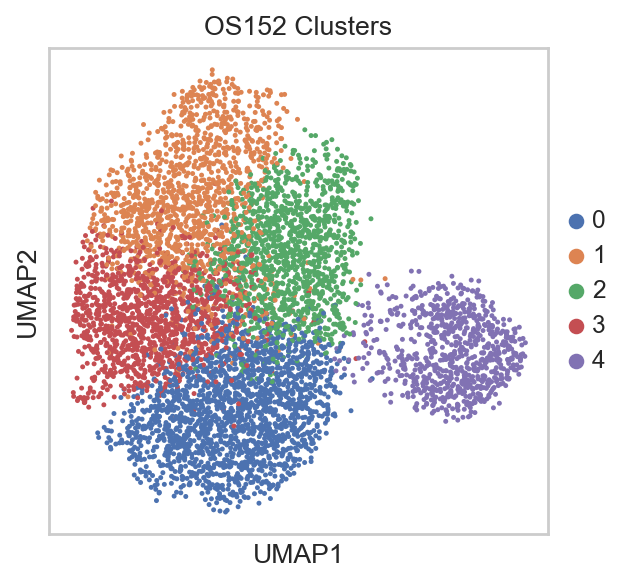

In [9]:
sc.tl.leiden(adata, resolution = 0.65)

sc.pl.umap(
    adata,
    color=["leiden"],
    frameon= True,
    title = "OS152 Clusters",
    size = 20
)

# preparing AnnData object for scvi model

In [2]:
# reading in the ccdifference scores
ccdifference = pd.read_csv("/Users/brendamelano/Desktop/os_data/OS152/CCdifference.csv")


# reading in the percent.mt scores
percent_mt = pd.read_csv("/Users/brendamelano/Desktop/os_data/OS152/percent.mt.csv")


# reading in the cell IDs from the seurat object
sample_obs = pd.read_csv("/Users/brendamelano/Desktop/os_data/OS152/cellID_obs_152.csv")


# removing the suffix and prefix from the index column within the adata object
adata.obs.index = adata.obs.index.map(lambda x: x.lstrip('OS152:').rstrip('x'))


# removing the suffix from the seurat barcodes
sample_obs["x"] = sample_obs["x"].map(lambda x: x.lstrip('').rstrip('-1'))


# filtering the adata object based on the seurat sample observations
adata = adata[np.isin(adata.obs.index, sample_obs["x"])]


# filtering genes to only keep those with 3 or more reads
sc.pp.filter_genes(adata, min_counts=50)


# filtering cells with counts less than 200
sc.pp.filter_cells(adata, min_counts = 200)


# making a copy of the counts to preserve them
adata.layers["counts"] = adata.X.copy() 


# normalizing the data
sc.pp.normalize_total(adata, target_sum=1e4)


# log normalizing the data
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`


# feature selection
sc.pp.highly_variable_genes(
    adata,
    n_top_genes = 3500, # try 3k or 4k
    subset = True,
    layer="counts",
    flavor="seurat_v3"
)

# creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# creating a list of sample observations and ccdifference scores
objs = [sample_obs, ccdifference]


# concatenating the objects
ccdif = pd.concat(objs, axis = 1, ignore_index = True)


# dropping the 1st column from the umap clusters df
ccdif = ccdif.drop(columns = 1)


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {0:'CellID'})


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {2:'ccdifference'})


# mkaing a list of objects to be concatenated
objs = [ccdif, percent_mt]


# concatenating the umap embeddings and the cluster identity
ccdif = pd.concat(objs, axis = 1, ignore_index = True)


# dropping the 3rd column from the umap clusters df
ccdif = ccdif.drop(columns = 2)


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {0:'CellID'})


# renaming the ccdifference column
ccdif = ccdif.rename(columns = {1:'ccdifference'})


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {3:'percent.mt'})


# ordering the umap object based on the sample index
ccdif_ordered = sample_one_index.merge(ccdif, on = "CellID")


# filtering the adata object based on the seurat sample observations
adata = adata[np.isin(adata.obs.index,ccdif["CellID"])]


# filtering the adata object based on the seurat sample observations
ccdif_ordered = ccdif_ordered[np.isin(ccdif_ordered["CellID"], adata.obs.index)]


# filtering the adata object based on the seurat sample observations
adata = adata[np.isin(adata.obs.index,ccdif_ordered["CellID"])]


# setting the index of the dataframe to 'CellID'
ccdif_ordered = ccdif_ordered.set_index('CellID')


# grabbing the ccdifference values
ccdif_values = ccdif_ordered['ccdifference']


adata.obs['ccdifference'] = ccdif_values.values


# adding ccdifference scores to the adata object
adata.obs['ccdifference'] = ccdif_ordered['ccdifference']


# adding percent mt reads to the adata object
adata.obs['percent.mt'] = ccdif_ordered['percent.mt']

... reading from cache file cache/Users-brendamelano-Desktop-10xver7-OS152-OS152.h5ad


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


filtered out 49953 genes that are detected in less than 50 counts


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:248: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/var/folders/lt/nhcx288j6jjfg45n3bhh1mjh0000gn/T/ipykernel_69652/2216643476.py:133: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['ccdifference'] = ccdif_values.values


In [4]:
# Setting up the anndata object to include continuous covariate variables
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    continuous_covariate_keys=["percent.mt" , "ccdifference" ] #,'S_score','G2M_score'
)

# creating a model for my adata object
model = scvi.model.SCVI(adata)

# inspecting the structure of the model
model


# training the model
model.train(train_size = 0.7, validation_size = 0.15)

# saving my model
#model.save("OS152_scvi_model/")

# loading the model
model = scvi.model.SCVI.load("OS152_scvi_model/", adata, use_gpu=False)

# clustering for scvi embedding

In [8]:
# saving the normalized expression values
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

# getting the latent representation
latent = model.get_latent_representation()


# adding the latent variables to the adata object
adata.obsm["X_scVI"] = latent


# using the scVI latent space to compute neighbors
sc.pp.neighbors(adata, use_rep="X_scVI")

# computing the umap embedding
sc.tl.umap(adata, min_dist=0.35)


# with 3000 variable genes
# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.47)

NameError: name 'model' is not defined

In [ ]:
# creating a dataframe with the cluster IDs
clusters = pd.DataFrame(adata.obs['leiden_scVI'].astype('int64').values)

# Define the number of clusters
n_clusters = len(clusters[0].unique())

# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_clusters)

# Create a dictionary that maps each cluster ID to a color from the palette
cluster_colors = dict(zip(sorted(clusters[0].unique()), colors))

# Map the cluster IDs to their corresponding colors
adata.uns['ClusterName_colors'] = [cluster_colors[c] for c in clusters[0]]


# Set the plot style to 'white' to remove grid lines
sns.set_style('white')

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


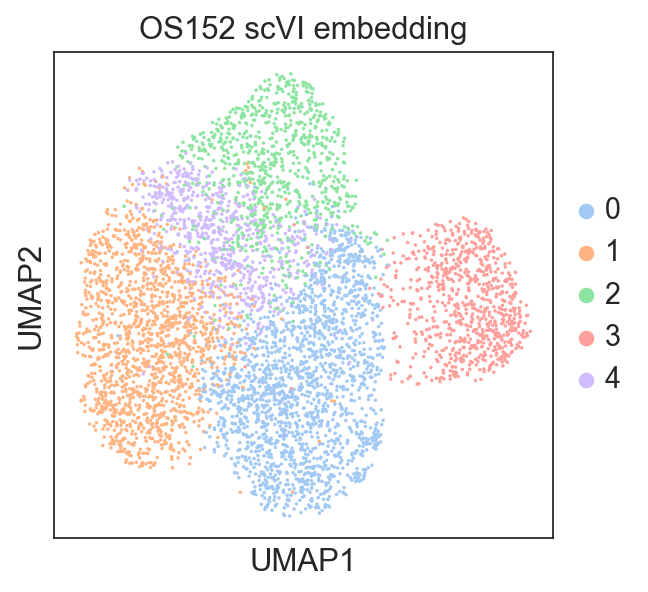

In [12]:
# plotting the clusters
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    frameon= True,
    title = "OS152 scVI embedding",
    size = 10,
    palette = colors
)

# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/os_data/OS152/scvi_152_adata.h5ad")

# DGEA for all clusters

In [15]:
# comparing each cell type to the rest
de_df = model.differential_expression(
    groupby="leiden_scVI",
)

# identifying the top marklers within each cluster
markers = {}

cats = adata.obs.leiden_scVI.cat.categories


for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_median > .9]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 2] #originally 2
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.15] # originall.1

    markers[c] = cell_type_df.index.tolist()[:30]
    
    adata.var_names_make_unique()

# heatmap
sc.pl.heatmap(
    adata, 
    markers, 
    groupby='leiden_scVI', 
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12)
)

# heatmap
sc.pl.heatmap(
    adata, 
    markers, 
    groupby='leiden_scVI', 
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12)
)

NameError: name 'model' is not defined

In [34]:
cluster_4_markers = de_df[de_df.group1 == '4'].index

In [38]:
file = open('/Users/brendamelano/Desktop/Subtype_A_genes.txt','w')
for item in cluster_4_markers:
    file.write(item+"\n")
file.close()

# DGEA for leiden clustering

In [10]:
# Performing DGEA between clusters
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')


cluster_markers = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(30)

# Selecting the subtype A markers
Subtype_A_genes_152 = cluster_markers.iloc[:, 1].tolist()

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


# pathway enrichment analysis

In [17]:
directory = '/Users/brendamelano/Desktop/gmt_files'

# Create a dictionary to store gene lists
gene_lists = {}

# Create variables for gene lists
for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        variable_name = os.path.splitext(filename)[0].upper()
        variable_name += "_genes"
        with open(os.path.join(directory, filename)) as f:
            gene_lists[variable_name] = [line.strip() for line in f]

# Create a dictionary to store gene scores for each module
gene_scores = {}

# Quantify enrichment for each gene list
for gene_list_name, gene_list in gene_lists.items():
    scores_key = gene_list_name + "_score"
    try:
        gene_scores[gene_list_name] = sc.tl.score_genes(
            adata, gene_list, ctrl_size=50, gene_pool=None,
            n_bins=5, score_name=scores_key, random_state=0, copy=False, use_raw=None
        )
    except KeyError:
        continue


computing score 'IL2_genes_score'
    finished: added
    'IL2_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'MTOR_genes_score'
    finished: added
    'MTOR_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'FOCAL_ADHESION_PI3KAKTMTOR_genes_score'
    finished: added
    'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    189 total control genes are used. (0:00:00)
computing score 'PDGF_ERK1_DOWN_genes_score'
    finished: added
    'PDGF_ERK1_DOWN_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'TNFA_genes_score'


    finished: added
    'TNFA_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'GCNP_genes_score'
    finished: added
    'GCNP_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'CSR_genes_score'
    finished: added
    'CSR_genes_score', score of gene set (adata.obs).
    146 total control genes are used. (0:00:00)
computing score 'ESC_genes_score'
    finished: added
    'ESC_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'PI3KAKTMTOR_genes_score'
    finished: added
    'PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    149 total control genes are used. (0:00:00)
computing score 'STK33_genes_score'
    finished: added
    'STK33_genes_score', score of gene set (adata.obs).
    193 total control genes are used. (0:00:00)
computing score 'VEGFA_genes_score'


    finished: added
    'VEGFA_genes_score', score of gene set (adata.obs).
    192 total control genes are used. (0:00:00)
computing score 'KRAS_genes_score'
    finished: added
    'KRAS_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'GLYCOLOSIS_genes_score'


ValueError: No valid genes were passed for scoring.

In [18]:
score_matrix = np.concatenate([gene_scores[module] for module in gene_scores.values()], axis=1)

KeyError: None

In [20]:
print(len(PI3KAKTMTOR_genes))

6


In [19]:
adata.var_names_make_unique()

# keeping only genes that appear in the adata
VEGFA_genes = [x for x in VEGFA_genes if x in adata.var_names]
print(len(VEGFA_genes))

NameError: name 'VEGFA_genes' is not defined

In [17]:
adata.var_names_make_unique()

# keeping only genes that appear in the adata
PI3KAKTMTOR = [x for x in PI3KAKTMTOR if x in adata.var_names]
print(len(PI3KAKTMTOR))

6


computing score 'VEGFA_score'
    finished: added
    'VEGFA_score', score of gene set (adata.obs).
    193 total control genes are used. (0:00:00)


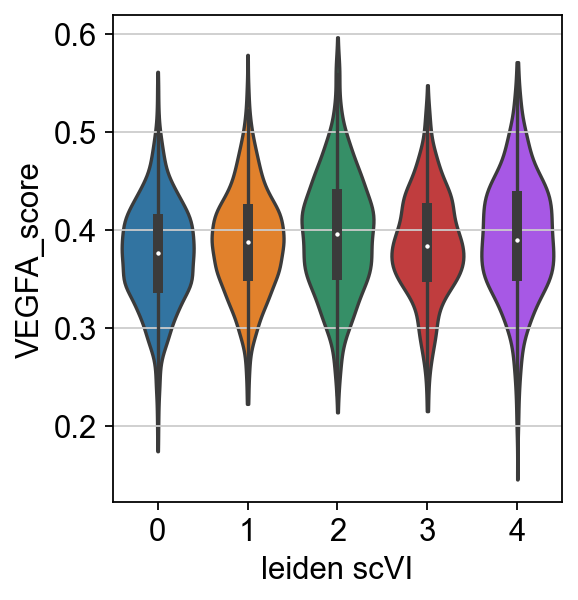

In [108]:
# computing gsea
sc.tl.score_genes(adata, VEGFA_genes, ctrl_size=50, gene_pool=None, n_bins=5, score_name='VEGFA_score', random_state=0, copy=False, use_raw=None)
sc.pl.violin(adata, ['VEGFA_score'], groupby='leiden_scVI', stripplot=False, inner='box')

computing score 'PI3KAKTMTOR'
    finished: added
    'PI3KAKTMTOR', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)


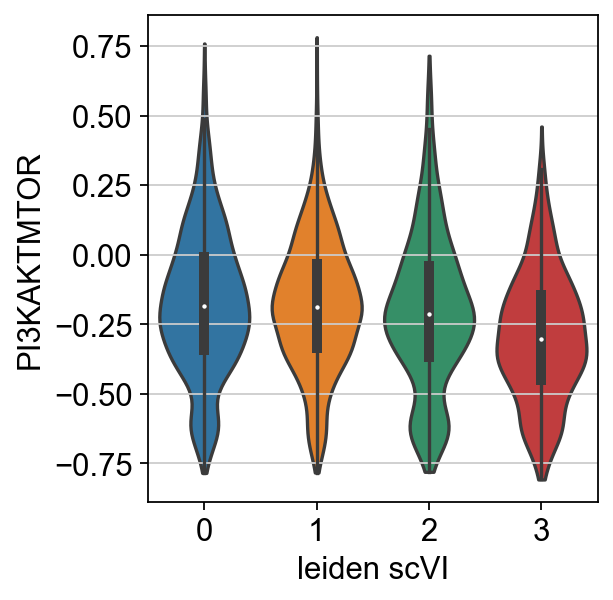

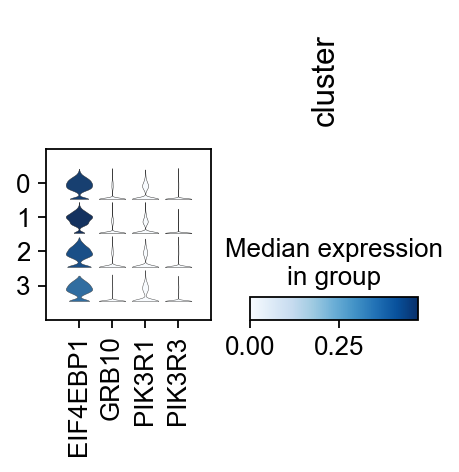

In [22]:
# computing gsea
sc.tl.score_genes(adata, PI3KAKTMTOR, ctrl_size=50, gene_pool=None, n_bins=25, score_name='PI3KAKTMTOR', random_state=0, copy=False, use_raw=None)
sc.pl.violin(adata, ['PI3KAKTMTOR'], groupby='leiden_scVI', stripplot=False, inner='box')


sc.pl.stacked_violin(adata, PI3KAKTMTOR, groupby='leiden_scVI',
                         var_group_positions=[(7, 8)], var_group_labels=['cluster'],
                    standard_scale="var",)

In [20]:
scores = [  'CSR_genes_score','MTOR_genes_score', 
          'PDGF_ERK1_DOWN_genes_score', 'TNFA_genes_score', 'GCNP_genes_score', 'IL2_genes_score', 
          'ESC_genes_score', 'FOCAL_ADHESION_PI3KAKTMTOR_genes_score',  'KRAS_genes_score', 
           'OXPHOS_genes_score', 'TGFB_genes_score',   
          'LEF1_genes_score', 'STK33_genes_score',]

sc.pl.heatmap(
    adata,
    scores,
    groupby='leiden_scVI',
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12)
)


ValueError: groupby has to be a valid observation. Given leiden_scVI, is not in observations: ['n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'S_score', 'G2M_score', 'phase', 'ccdifference', 'leiden', 'IL2_genes_score', 'MTOR_genes_score', 'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', 'PDGF_ERK1_DOWN_genes_score', 'TNFA_genes_score', 'GCNP_genes_score', 'CSR_genes_score', 'ESC_genes_score', 'PI3KAKTMTOR_genes_score', 'STK33_genes_score', 'VEGFA_genes_score', 'KRAS_genes_score'] or index name "CellID"

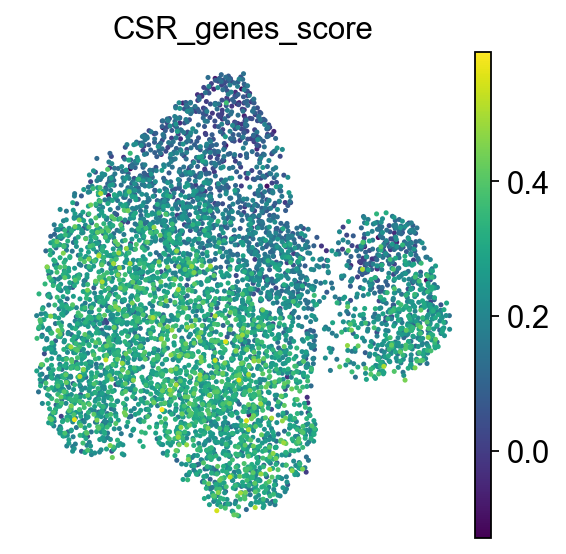

In [56]:
sc.pl.umap(
    adata,
    color=["CSR_genes_score"],
    frameon=False,
)

# Immune Modulating Source Genes

In [ ]:
# performing dgea between the angiogenic early and late clusters
de_df = model.differential_expression(
    groupby = "leiden_scVI",
    group1="1",
    group2="0"
)

de_df.head(20)

In [54]:
de_df.head(20).index
im_source_genes = de_df.head(30).index
sc.pl.heatmap(
    adata, 
    im_source_genes, 
    groupby='leiden_scVI', 
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12)
)

Index(['CDC20', 'CCNB1', 'ARHGAP19', 'PLK1', 'GDF6', 'ENSG00000250135',
       'HLA-DRA', 'FAM111B', 'PLXNA4', 'PIMREG', 'ENSG00000285448', 'DLGAP5',
       'KIF20A', 'RPS3AP27', 'CENPE', 'ENSG00000287218', 'H2AC20', 'LEP',
       'CNKSR1', 'CLMAT3'],
      dtype='object', name='Gene')

In [ ]:
# performing dgea between two subtypes
de_df = model.differential_expression(
    groupby='leiden_scVI',
    group1='0',
    group2='2'
)

de_df

# Performing DGEA between subtypes

In [73]:
# performing dgea between two subtypes
de_df = model.differential_expression(
    groupby='Subtype',
)

de_df

DE...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/it]


proba_de  proba_not_de  bayes_factor    scale1    scale2  \
Gene                                                               
EDN1      0.9646        0.0354      3.305001  0.000051  0.000026   
MLC1      0.9640        0.0360      3.287572  0.000003  0.000011   
BMP7      0.9612        0.0388      3.209762  0.000032  0.000009   
PRELP     0.9610        0.0390      3.204413  0.000034  0.000081   
COL8A1    0.9586        0.0414      3.142193  0.000011  0.000009   
...          ...           ...           ...       ...       ...   
EZR       0.5598        0.4402      0.240350  0.002305  0.002250   
GAPDH     0.5560        0.4440      0.224944  0.007579  0.007606   
ACTG1     0.5482        0.4518      0.193401  0.020345  0.018432   
CTHRC1    0.5478        0.4522      0.191786  0.002593  0.002702   
RPS12     0.5308        0.4692      0.123356  0.014795  0.013784   

        pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
Gene                                                         ...              
EDN1             0.0   0.25  3.259432    3.080210  4.687179  ...   0.038083   
MLC1             0.0   0.25 -0.710489   -0.838564  4.482593  ...   0.001313   
BMP7             0.0   0.25  2.894911    2.946060  3.469495  ...   0.042679   
PRELP            0.0   0.25 -1.394733   -1.486769  4.314857  ...   0.036770   
COL8A1           0.0   0.25  2.179832    2.155676  4.270614  ...   0.012475   
...              ...    ...       ...         ...       ...  ...        ...   
EZR              0.0   0.25  0.042795    0.039380  0.428473  ...   4.646163   
GAPDH            0.0   0.25  0.003041    0.007740  0.423697  ...  17.271816   
ACTG1            0.0   0.25  0.153406    0.151819  0.398369  ...  44.552574   
CTHRC1           0.0   0.25 -0.054484   -0.050367  0.422626  ...   5.097450   
RPS12            0.0   0.25  0.117761    0.101952  0.415079  ...  32.873089   

        raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
Gene                                                              
EDN1     0.013405               0.023638               0.005174   
MLC1     0.012935               0.001313               0.012465   
BMP7     0.008467               0.039396               0.007761   
PRELP    0.060913               0.022981               0.037629   
COL8A1   0.007526               0.011162               0.006820   
...           ...                    ...                    ...   
EZR      4.128746               0.964103               0.945345   
GAPDH   15.535563               1.000000               0.999800   
ACTG1   37.547352               1.000000               1.000000   
CTHRC1   5.107351               0.975641               0.962563   
RPS12   27.635227               0.998718               0.999800   

        raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
Gene                                                                 
EDN1                0.191303              0.083930            True   
MLC1                0.005114              0.066142            True   
BMP7                0.189387              0.054285            True   
PRELP               0.159865              0.342915            True   
COL8A1              0.050643              0.040982            True   
...                      ...                   ...             ...   
EZR                24.156498             23.260242           False   
GAPDH              87.767464             86.492928           False   
ACTG1             229.011841            208.632401           False   
CTHRC1             26.376705             28.804045           False   
RPS12             166.922913            151.966934           False   

               comparison     group1 group2  
Gene                                         
EDN1       Source vs Rest     Source   Rest  
MLC1       Source vs Rest     Source   Rest  
BMP7       Source vs Rest     Source   Rest  
PRELP      Source vs Rest     Source   Rest  
COL8A1     Source vs Rest     Source

In [74]:
# identifying the top marklers within each cluster
markers = {}

cats = adata.obs.Subtype.cat.categories


for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_median > 1.2]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 2] #originally 2
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:30]

KeyError: 'Subtype'

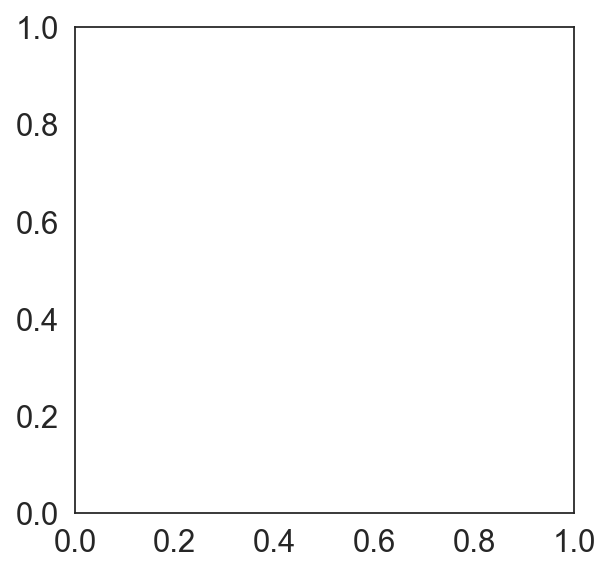

In [13]:
# plotting the clusters
sc.pl.umap(
    adata,
    color=["Subtype"],
    frameon= True,
    title = "OS152 scVI embedding",
    size = 10
)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_Subtype']`


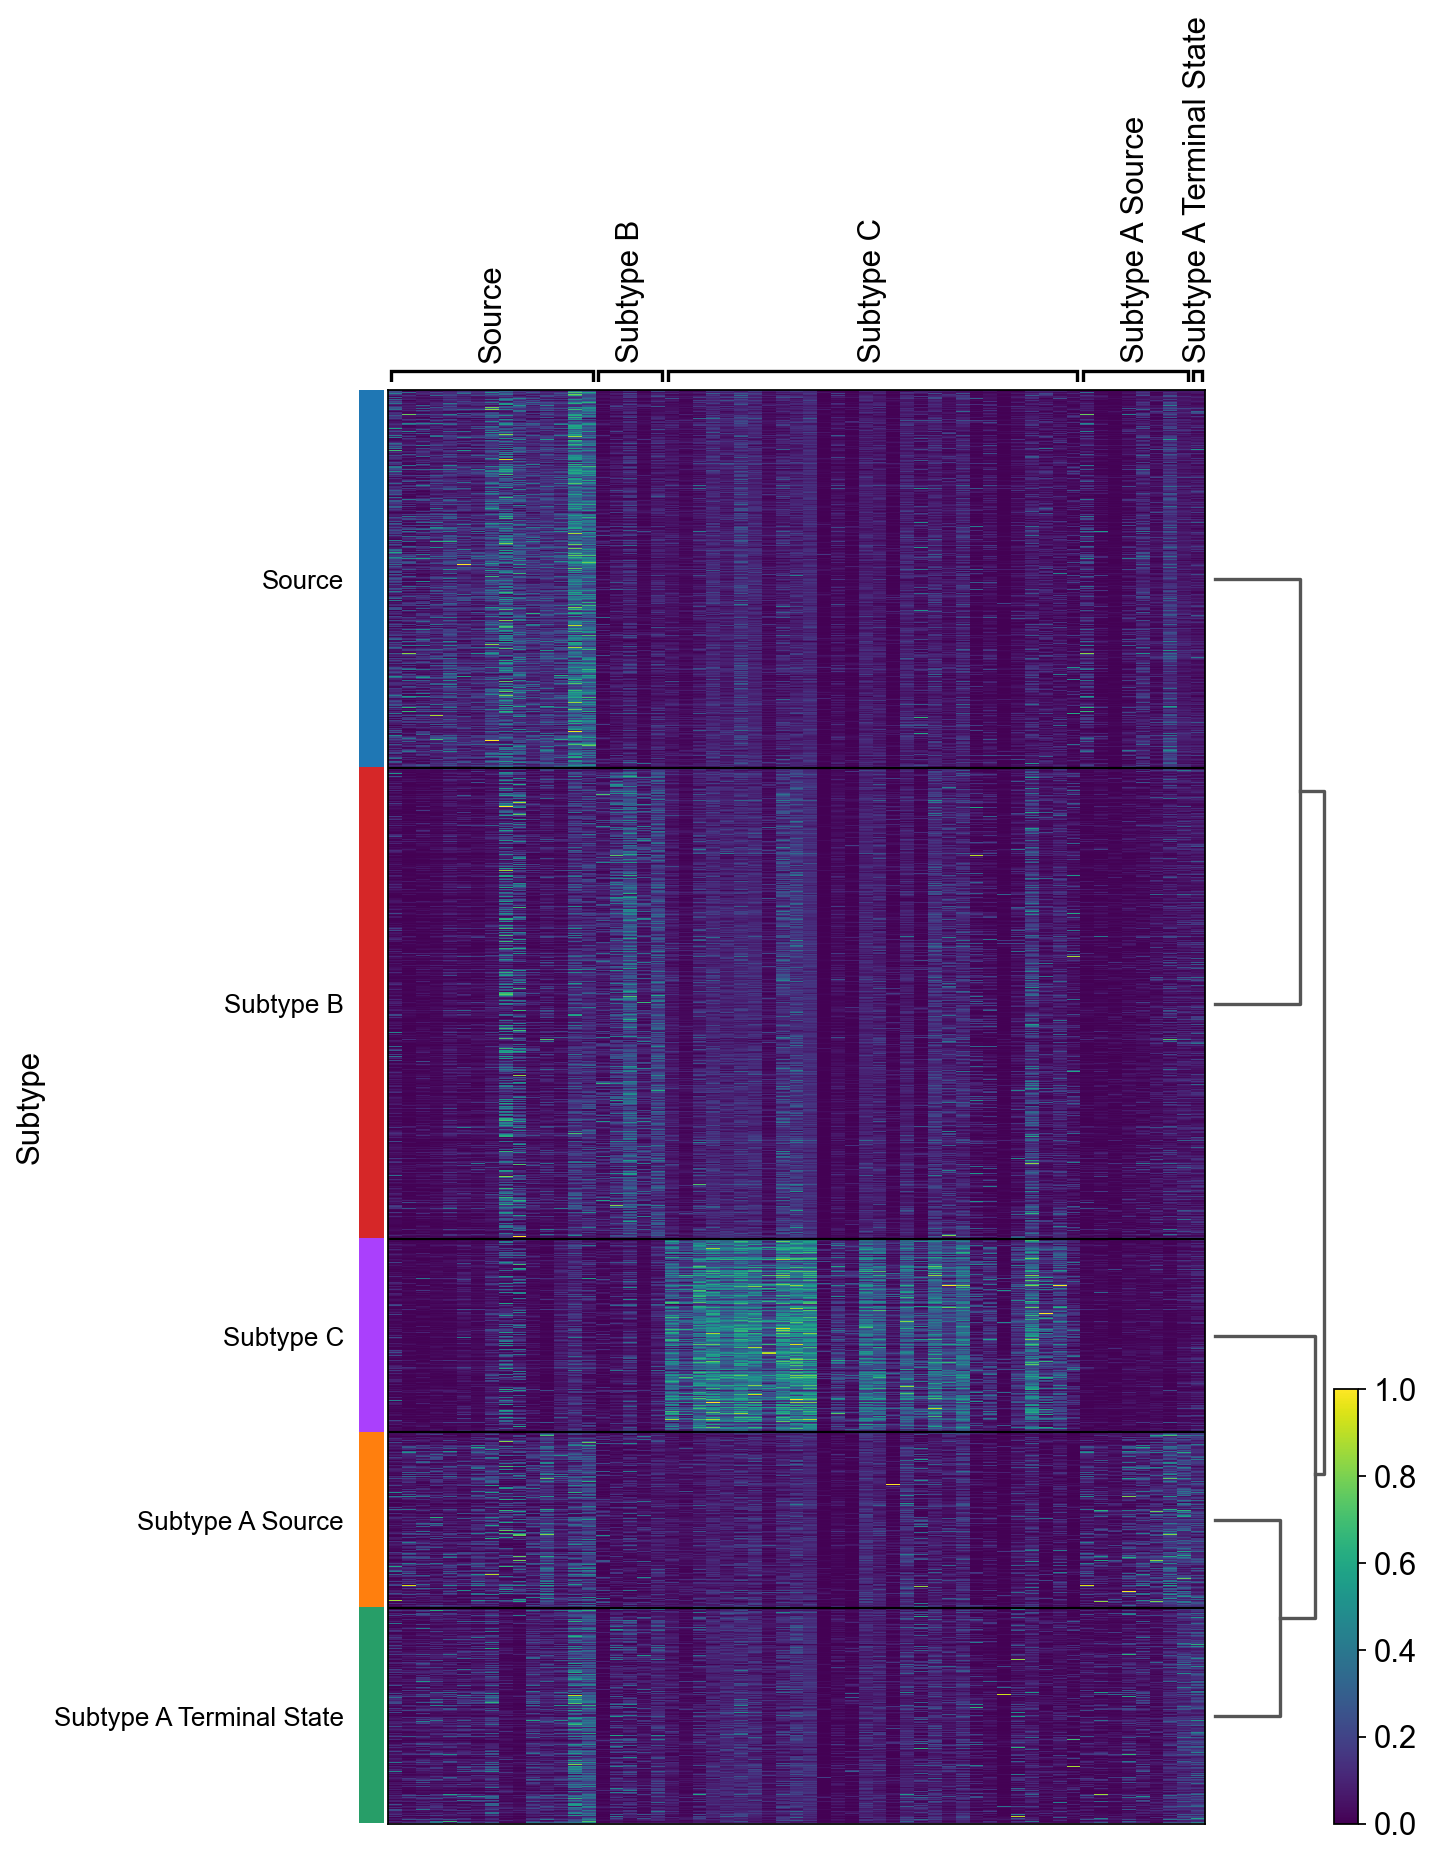

In [58]:
sc.pl.heatmap(
    adata, 
    markers, 
    groupby='Subtype', 
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12)
)

In [77]:
markers

{'Source': ['MGLL',
  'TUBA4A',
  'GALNT14',
  'F2R',
  'PRKAA2',
  'HLA-B',
  'MATK',
  'PSRC1',
  'H4C3',
  'KIFC1',
  'AK4',
  'CYBA',
  'SERINC2',
  'EPHB2',
  'CIBAR1'],
 'Subtype A': ['MGLL', 'H2BC5', 'ADM', 'H2AC6', 'H2BC4'],
 'Subtype B': ['CA3', 'TAC3', 'CFAP251', 'LINC01549', 'SLC2A1'],
 'Subtype C': ['HEY1',
  'ZNF704',
  'BASP1',
  'TMEM70',
  'S100A4',
  'ELOC',
  'LUM',
  'DCN',
  'PEX2',
  'RPL7',
  'MXRA8',
  'BHMT2',
  'MARK1',
  'MYLPF',
  'ZFHX4',
  'TERF1',
  'SGCA',
  'SHOX2',
  'EPHX1',
  'PRRX1',
  'DSP',
  'IBSP',
  'PLAAT3',
  'PPP1R14C',
  'ZBTB10',
  'KRT18',
  'IL4R',
  'GNG4',
  'COL3A1',
  'PTK7']}

In [21]:
markers = {'Source': ['MGLL',
  'TUBA4A',
  'GALNT14',
  'F2R',
  'HLA-B',
  'MATK',
  'PSRC1',
  'H4C3',
  'KIFC1',
  'AK4',
  'CYBA',
  'SERINC2',
  'EPHB2',
  'CIBAR1'],
 'Subtype A': ['MGLL', 'H2BC5', 'H2AC6', 'H2BC4'],
 'Subtype B': ['CA3', 'TAC3', 'CFAP251', 'LINC01549', 'SLC2A1'],
 'Subtype C': ['HEY1',
  'ZNF704',
  'BASP1',
  'TMEM70',
  'S100A4',
  'ELOC',
  'LUM',
  'DCN',
  'PEX2',
  'RPL7',
  'MXRA8',
  'BHMT2',
  'MARK1',
  'MYLPF',
  'ZFHX4',
  'TERF1',
  'SGCA',
  'SHOX2',
  'EPHX1',
  'PRRX1',
  'DSP',
  'IBSP',
  'PLAAT3',
  'ZBTB10',
  'KRT18',
  'IL4R',
  'GNG4',
  'COL3A1']}

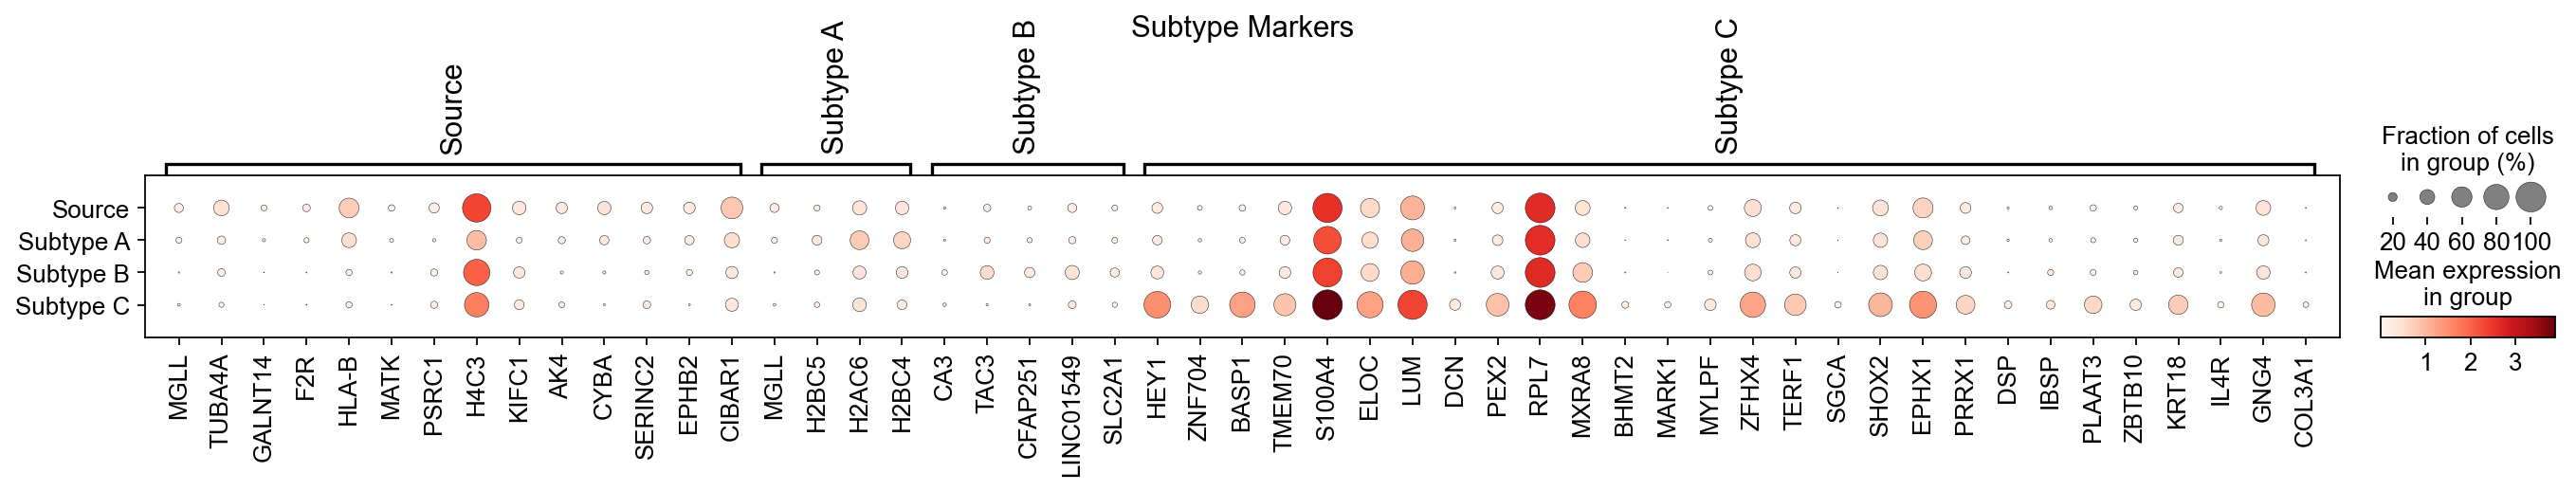

In [81]:
sc.pl.dotplot(adata, markers, 'Subtype', title = 'Subtype Markers')

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


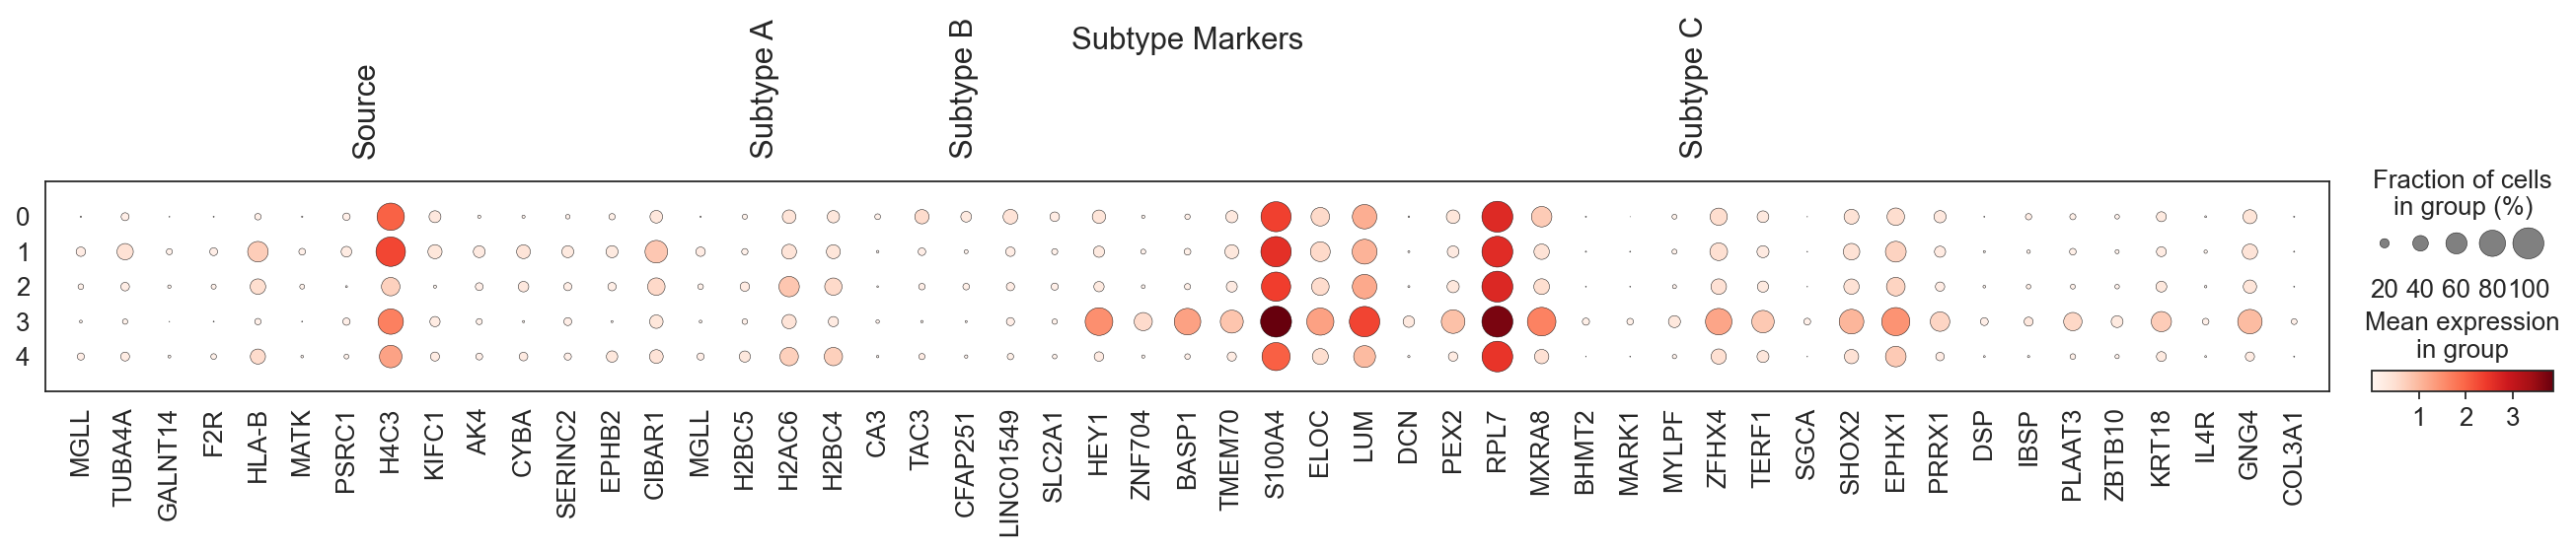

In [22]:
sc.pl.dotplot(adata, markers, 'leiden_scVI', title = 'Subtype Markers')

# Angiogenic score

computing score 'angiogenic_score'
    finished: added
    'angiogenic_score', score of gene set (adata.obs).
    201 total control genes are used. (0:00:00)


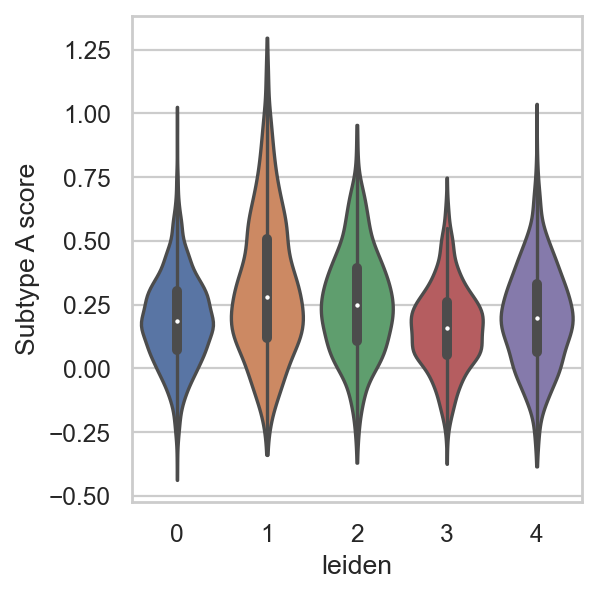

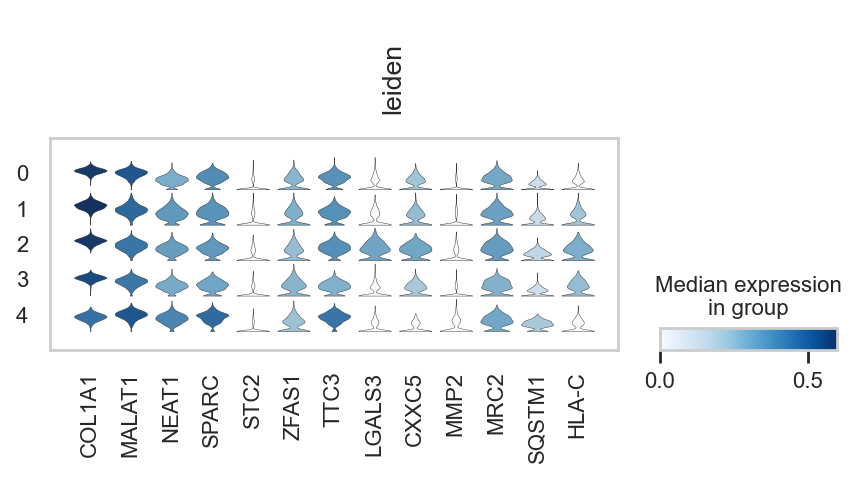

In [12]:
# reading in gene lists for gsea
angiogenic_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/angiogenic_markers.csv')]


adata.var_names_make_unique()

# keeping only genes that appear in the adata
angiogenic_genes = [x for x in angiogenic_genes if x in adata.var_names]


# computing gsea
sc.tl.score_genes(adata, angiogenic_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='angiogenic_score', random_state=0, copy=False, use_raw=None)

sc.pl.violin(adata, ['angiogenic_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel = 'Subtype A score')


sc.pl.stacked_violin(adata, angiogenic_genes, groupby='leiden',
                         var_group_positions=[(7, 8)], var_group_labels=['leiden'],
                    standard_scale="var",)

# combining the clusters

In [8]:
adata.obs['leiden_scVI'] = adata.obs['leiden_scVI'].astype('category')

adata.obs['leiden_scVI'][adata.obs['leiden_scVI']=='0']='1'

adata.obs['leiden_scVI'][adata.obs['leiden_scVI']=='4']='2'

adata.obs['leiden_scVI'][adata.obs['leiden_scVI']=='3']='5'


# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'esc': ['5'], 'immuneModulating': ['1'], 'angiogenic': ['2']}


# Initialize empty column in cell metadata
adata.obs['subtype'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden_scVI).isin(cell_dict[i])
    adata.obs.loc[ind,'subtype'] = i

    
sc.pl.umap(adata, color=['subtype'], legend_fontsize=9)

sc.pl.umap(adata, color=['leiden'], legend_fontsize=9)

In [11]:
# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/os_data/OS152/scvi_152_adata_subtypes.h5ad")

# Computing the angiogenic score

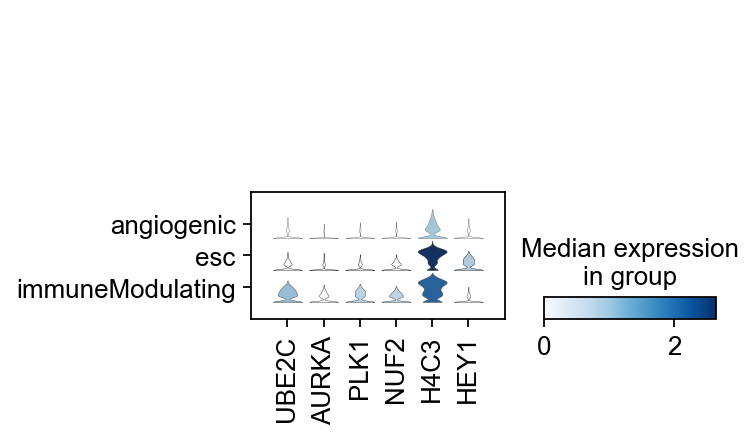

In [40]:
sc.pl.stacked_violin(adata, ["UBE2C", "AURKA", "PLK1", "NUF2", "H4C3", "HEY1"], groupby = 'subtype')

In [22]:
sc.pl.heatmap(
    adata, 
    angi_genes, 
    groupby='leiden', 
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12)
)

NameError: name 'angi_genes' is not defined

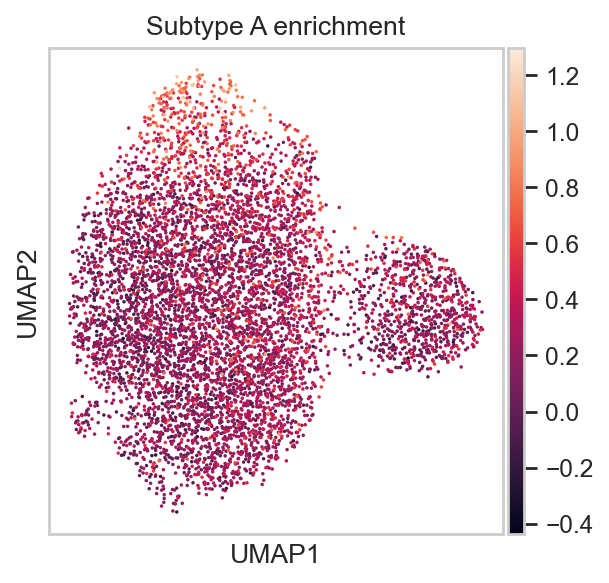

In [23]:
sc.pl.umap(
    adata,
    color=["angiogenic_score"],
   # frameon=False,
    title = 'Subtype A enrichment',
    size = 10,
    legend_fontsize = 7
)

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


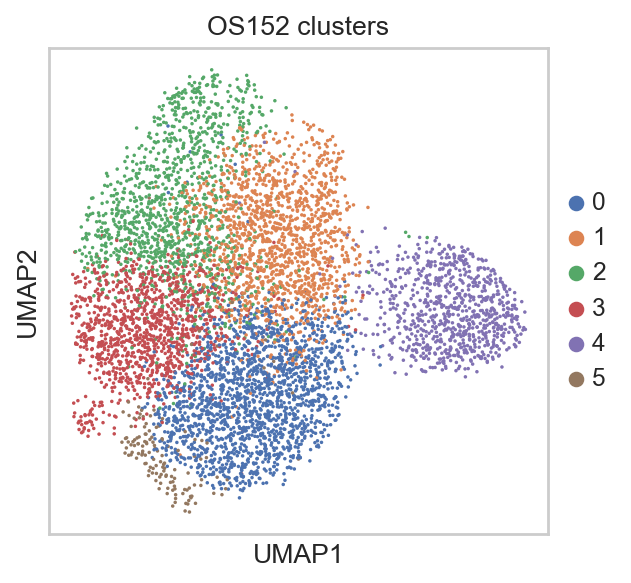

In [24]:
# plotting the clusters
sc.pl.umap(
    adata,
    color=["leiden"],
     title = 'OS152 clusters',
    #frameon=False,
    size = 10
)

# Computing the subtype "B" (Immune Modulating) score

In [11]:
# reading in gene lists for gsea
ImmuneModulating_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/immune_modulating_genes.csv')]
adata.var_names_make_unique()

sc.tl.score_genes(adata, ImmuneModulating_genes, ctrl_size=50, gene_pool=None, n_bins=25, score_name='ImmuneModulating_score', random_state=0, copy=False, use_raw=None)



computing score 'ImmuneModulating_score'
    finished: added
    'ImmuneModulating_score', score of gene set (adata.obs).
    195 total control genes are used. (0:00:00)


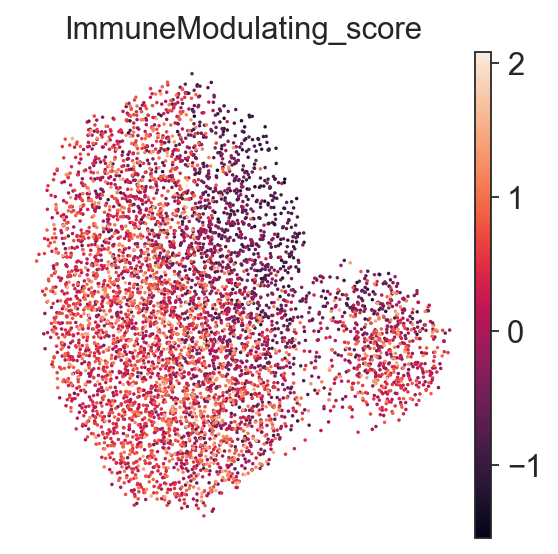

In [26]:
sc.pl.umap(
    adata,
    color=["ImmuneModulating_score"],
    frameon=False,
    legend_fontsize=9,
    size = 10
)

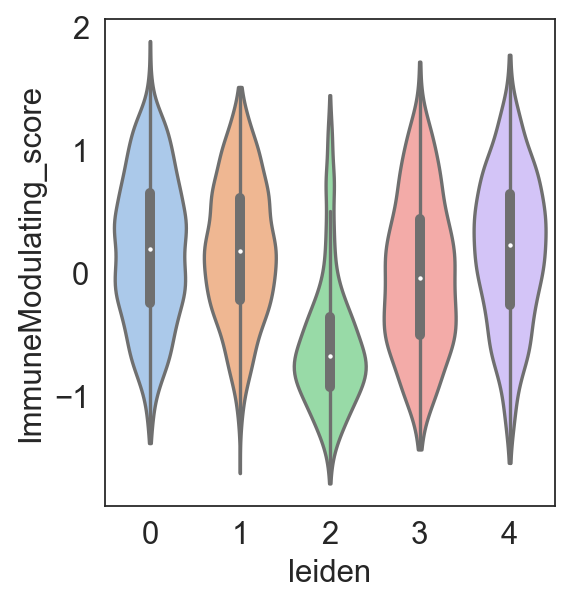

In [12]:
sc.pl.violin(adata, ['ImmuneModulating_score'], groupby='leiden', stripplot=False, inner='box')

# Subtype "C" ESC subtype enrichment

computing score 'ImmuneModulating_score'
    finished: added
    'ImmuneModulating_score', score of gene set (adata.obs).
    248 total control genes are used. (0:00:00)


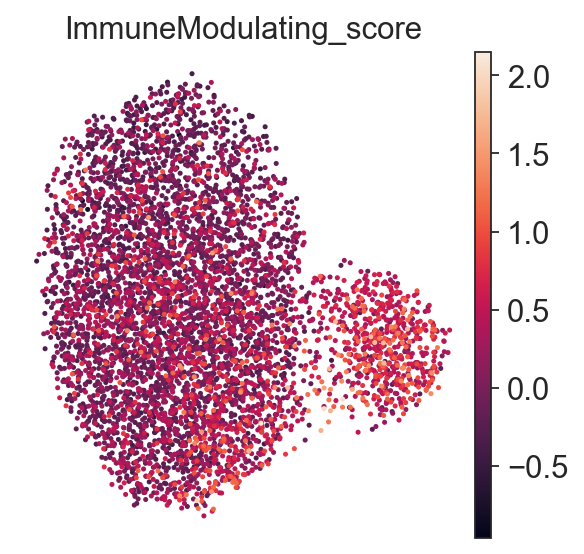

KeyError: "Could not find keys '['leiden_scVI']' in columns of `adata.obs` or in adata.raw.var_names."

In [29]:
# reading in gene lists for gsea
ImmuneModulating_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/esc_markers.csv')]
adata.var_names_make_unique()

sc.tl.score_genes(adata, ImmuneModulating_genes, ctrl_size=50, gene_pool=None, n_bins=25, score_name='ImmuneModulating_score', random_state=0, copy=False, use_raw=None)

sc.pl.umap(
    adata,
    color=["ImmuneModulating_score"],
    frameon=False,
)

sc.pl.violin(adata, ['ImmuneModulating_score'], groupby='leiden_scVI', stripplot=False, inner='box')

# Labeling the Angiogenic Source and Terminal State

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


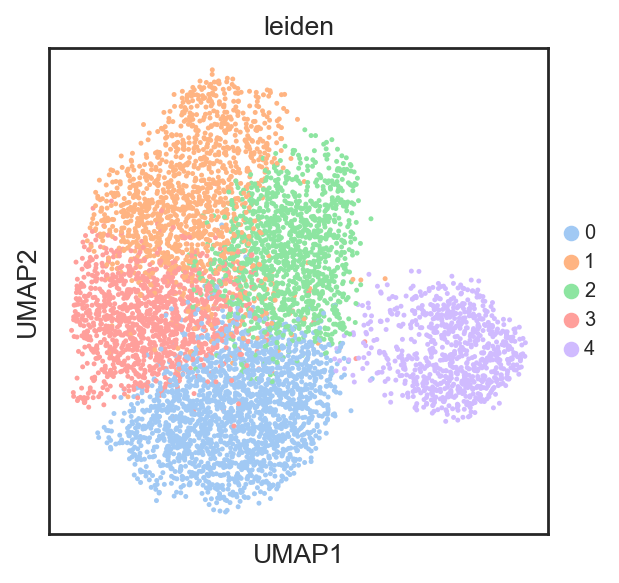

In [17]:
sc.pl.umap(adata, color=['leiden'], legend_fontsize=9, size = 20)

In [15]:
adata.obs['leiden'] = adata.obs['leiden'].astype('category')

adata.obs['leiden'][adata.obs['leiden']=='4']='2'
adata.obs['leiden'][adata.obs['leiden']=='0']='1'

# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'Subtype A': ['1'],  'Subtype B': ['1'], 'Subtype C':['3']}


# Initialize empty column in cell metadata
adata.obs['Subtype'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'Subtype'] = i

# creating a dataframe with the cluster IDs
subtypes = pd.DataFrame(adata.obs['Subtype'].values)

# Define the number of clusters
n_subtypes = len(subtypes[0].unique())

# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_subtypes)

# Create a dictionary that maps each cluster ID to a color from the palette
subtype_colors = dict(zip(sorted(subtypes[0].unique()), colors))

# Map the cluster IDs to their corresponding colors
adata.uns['subtype_colors'] = [subtype_colors[c] for c in subtypes[0]]

sc.pl.umap(adata, color=['Subtype'], legend_fontsize=9, title = "OS152 Subtypes", palette = subtype_colors)

In [2]:
# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/OS152_adata_labeled.h5ad")

adata = sc.read("/Users/brendamelano/Desktop/OS152_adata_labeled.h5ad")


In [3]:
# performing dgea between two subtypes
de_df = model.differential_expression(
    groupby='Subtype',
    group1='Subtype B',
    group2='Subtype C'
)

de_df.head(25)

NameError: name 'model' is not defined

In [47]:
# Identifying the top markers within each cluster
markers = {}

cats = adata.obs.Subtype.cat.categories


for i, c in enumerate(cats):
    cid = "{} vs Subtype B".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_median > 1]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 2] #originally 2
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:30]
    
Subtype_B_genes = de_df.head(30)

In [50]:
Subtype_B_genes = de_df.head(30).index

In [51]:
Subtype_B_genes

Index(['ZNF704', 'AMBN', 'LY96', 'S100A4', 'HEY1', 'MAGEA1', 'MARK1', 'TIMP1',
       'MLC1', 'DPEP1', 'ARHGAP28', 'LSR', 'COL27A1', 'COL8A1', 'LUM', 'BACE2',
       'BMP8A', 'EPHX1', 'TMEM70', 'ST8SIA4', 'INTS4P1', 'DCN', 'PPP1R14C',
       'PLK2', 'BASP1', 'IFI44', 'MSX2', 'KCNN4', 'ENSG00000287289', 'SGCA'],
      dtype='object', name='Gene')

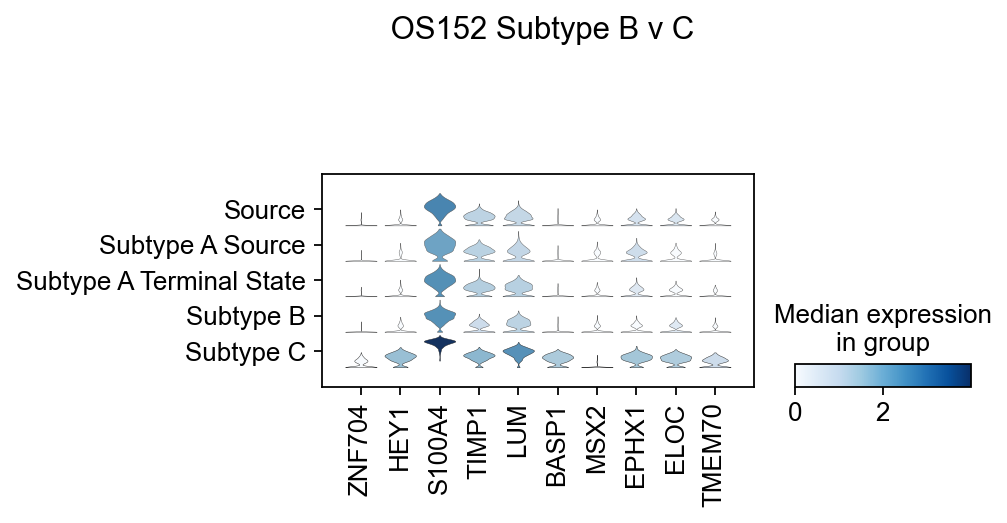

In [53]:
sc.pl.stacked_violin(adata, ['ZNF704', 'HEY1', 'S100A4', 
       'TIMP1', 'LUM',
      'BASP1', 'MSX2',  'EPHX1',
          'ELOC',  'TMEM70'], groupby = 'Subtype',
                    title = ' OS152 Subtype B v C')

# DGE for Subtype A v subtype B

In [64]:
# performing dgea between two subtypes
de_df = model.differential_expression(
    groupby='Subtype',
    group1='Subtype A',
    group2='Subtype B'
)

de_df.head(25)

DE...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


proba_de  proba_not_de  bayes_factor    scale1    scale2  \
Gene                                                                        
EDN1               0.9720        0.0280      3.547151  0.000051  0.000006   
AMBN               0.9652        0.0348      3.322718  0.000012  0.000049   
MYMX               0.9648        0.0352      3.310874  0.000010  0.000047   
PCSK1N             0.9642        0.0358      3.293351  0.000023  0.000056   
WFDC21P            0.9618        0.0382      3.225971  0.000030  0.000003   
COL11A1            0.9610        0.0390      3.204413  0.000017  0.000044   
PRELP              0.9602        0.0398      3.183274  0.000050  0.000101   
COL8A1             0.9586        0.0414      3.142193  0.000007  0.000002   
BMP7               0.9572        0.0428      3.107474  0.000019  0.000004   
CCND1              0.9566        0.0434      3.092926  0.000074  0.000012   
GUCY1B1            0.9550        0.0450      3.055049  0.000019  0.000007   
LRRN3              0.9548        0.0452      3.050405  0.000006  0.000013   
WNT1               0.9544        0.0456      3.041175  0.000015  0.000042   
MLC1               0.9538        0.0462      3.027474  0.000003  0.000005   
MGLL               0.9532        0.0468      3.013941  0.000113  0.000023   
PECAM1             0.9526        0.0474      3.000573  0.000009  0.000019   
ENSG00000289609    0.9522        0.0478      2.991749  0.000017  0.000019   
PLXDC2             0.9522        0.0478      2.991749  0.000039  0.000009   
NPR3               0.9516        0.0484      2.978645  0.000009  0.000003   
LAYN               0.9514        0.0486      2.974311  0.000042  0.000008   
RAB28              0.9508        0.0492      2.961410  0.000007  0.000029   
CELF2              0.9506        0.0494      2.957143  0.000033  0.000018   
PPP1R14C           0.9498        0.0502      2.940236  0.000048  0.000013   
GPRC5A             0.9498        0.0502      2.940236  0.000009  0.000012   
SYT6               0.9486        0.0514      2.915349  0.000033  0.000006   

                 pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  \
Gene                                                                  ...   
EDN1                      0.0   0.25  2.949963    2.987949  5.220713  ...   
AMBN                      0.0   0.25 -4.115871   -3.884342  4.764729  ...   
MYMX                      0.0   0.25 -2.944900   -2.957984  4.456205  ...   
PCSK1N                    0.0   0.25 -3.012554   -3.037530  4.402916  ...   
WFDC21P                   0.0   0.25  3.246692    3.219694  3.374081  ...   
COL11A1                   0.0   0.25 -2.506137   -2.702942  4.379478  ...   
PRELP                     0.0   0.25 -2.304880   -2.289643  4.236744  ...   
COL8A1                    0.0   0.25  1.027570    0.982216  4.632133  ...   
BMP7                      0.0   0.25  1.378773    1.512875  4.061261  ...   
CCND1                     0.0   0.25  2.340786    2.441278  3.380916  ...   
GUCY1B1                   0.0   0.25  0.666419    0.920136  4.370975  ...   
LRRN3                     0.0   0.25 -1.505502   -1.561253  3.938248  ...   
WNT1                      0.0   0.25 -2.415358   -2.331120  3.651340  ...   
MLC1                      0.0   0.25 -0.639965   -0.564755  4.548094  ...   
MGLL                      0.0   0.25  2.479237    2.526040  2.338067  ...   
PECAM1                    0.0   0.25 -1.955000   -1.938471  3.630999  ...   
ENSG00000289609           0.0   0.25 -1.079663   -0.953492  4.442750  ...   
PLXDC2                    0.0   0.25  2.148519    2.117951  3.395107  ...   
NPR3                      0.0   0.25  1.486779    1.533042  3.487604  ...   
LAYN                      0.0   0.25  2.263188    2.289523  2.799381  ...   
RAB28                     0.0   0.25 -2.137691   -2.091289  3.034888  ...   
CELF2                     0.0   0.25  1.331535    1.501121  3.367222  ...   
PPP1R14C                  0.0   0.25  2.283097    2.202567  3.299788  ...   
GPRC5A      

In [70]:
# Identifying the top markers within each cluster
markers = {}

cats = adata.obs.Subtype.cat.categories


for i, c in enumerate(cats):
    cid = "{} vs Subtype A".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_median > 1]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 2] #originally 2
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:30]

In [71]:
Subtype_B_genes = de_df.head(30).index

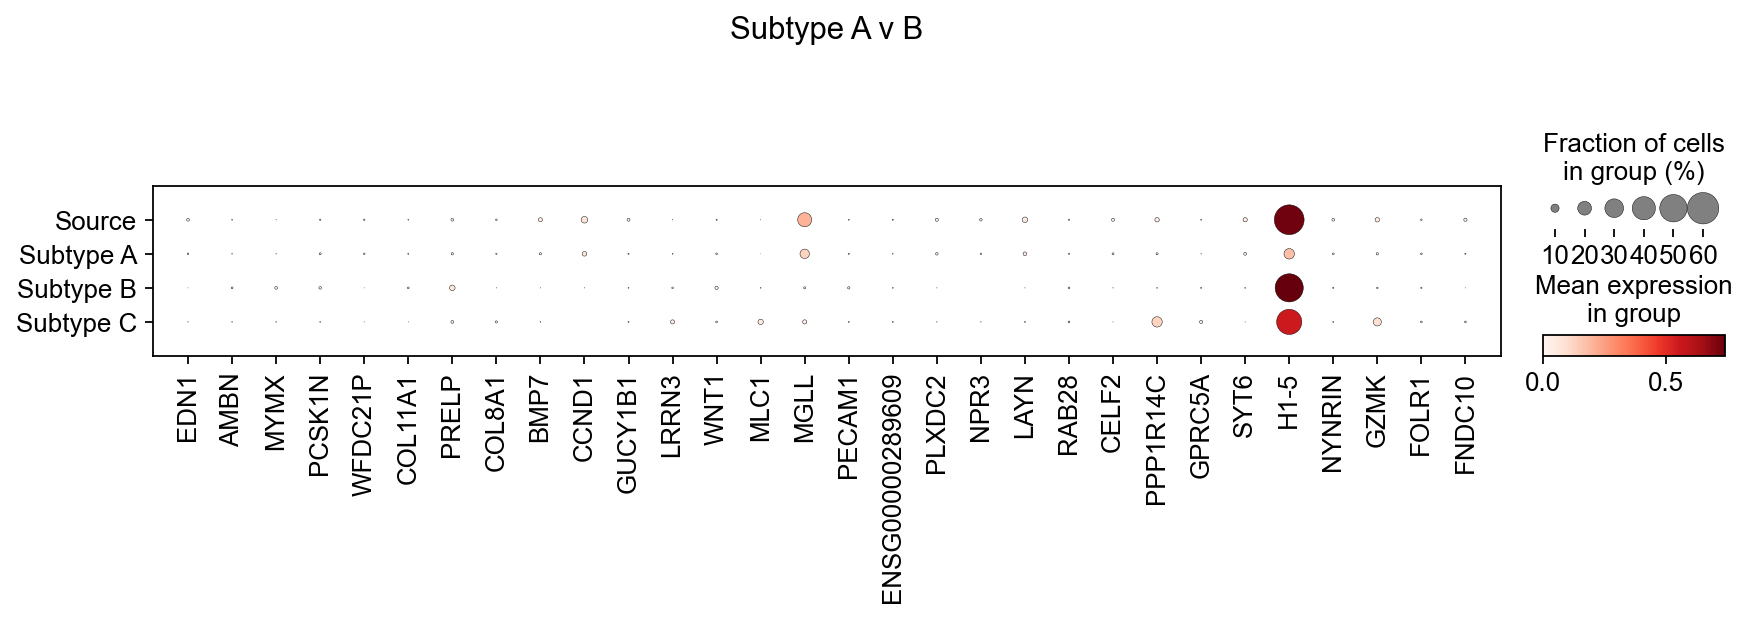

In [72]:
sc.pl.dotplot(adata, Subtype_B_genes, 'Subtype', title = 'Subtype A v B')

# comparing the esc source and terminal state

In [ ]:
# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'esc_source': ['3'], 'esc_terminal': ['5']}


# Initialize empty column in cell metadata
#adata.obs['esc_Source'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden_scVI).isin(cell_dict[i])
    adata.obs.loc[ind,'source'] = i

    
sc.pl.umap(adata, color=['source'], legend_fontsize=9)

# performing dgea between two subtypes
de_df = model.differential_expression(
    groupby='esc_Source',
    group1='esc_source',
    group2='esc_terminal'
)

de_df.head(30)

# Comparing the immune modulating source and terminal state

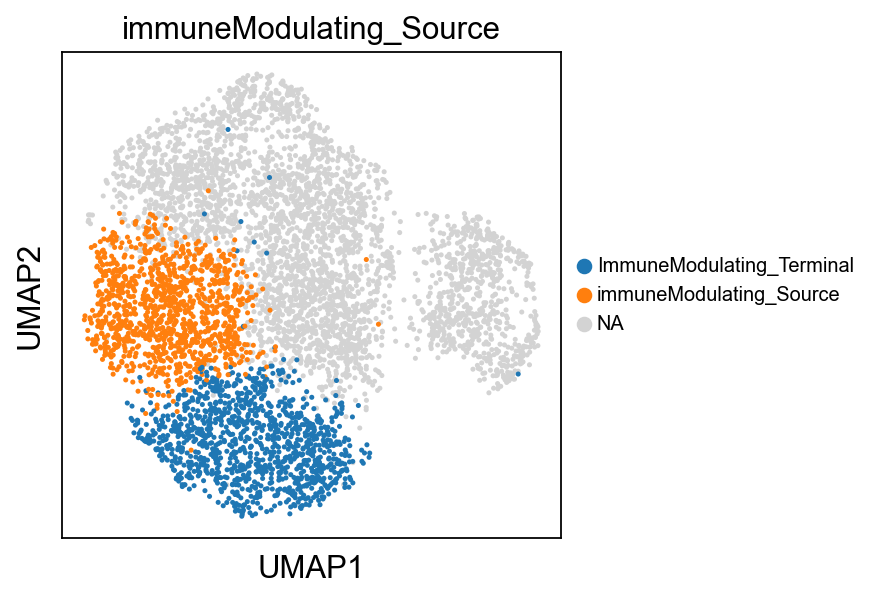

In [96]:
# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'immuneModulating_Source': ['1'], 'ImmuneModulating_Terminal': ['0']}


# Initialize empty column in cell metadata
adata.obs['immuneModulating_Source'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden_scVI).isin(cell_dict[i])
    adata.obs.loc[ind,'immuneModulating_Source'] = i

    
sc.pl.umap(adata, color=['immuneModulating_Source'], legend_fontsize=9)

In [88]:
# computing gsea
sc.tl.score_genes(adata, angi_genes, ctrl_size=50, gene_pool=None, n_bins=25, score_name='angi_score', random_state=0, copy=False, use_raw=None)

computing score 'angi_score'
    finished: added
    'angi_score', score of gene set (adata.obs).
    341 total control genes are used. (0:00:00)


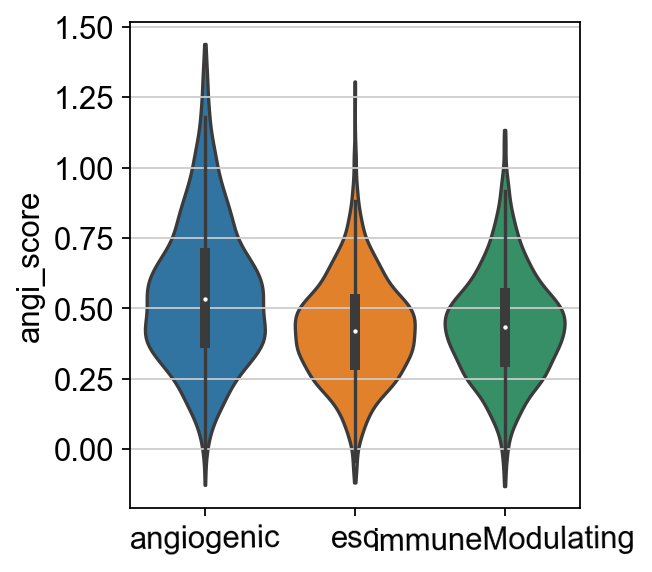

In [92]:
sc.pl.violin(adata, ['angi_score'], groupby='subtype', stripplot=False, inner='box', rotation = 0.7)

In [ ]:
# scoring genes with trajectories as comparisons instead of clusters

# Angiogenic Source v Terminal

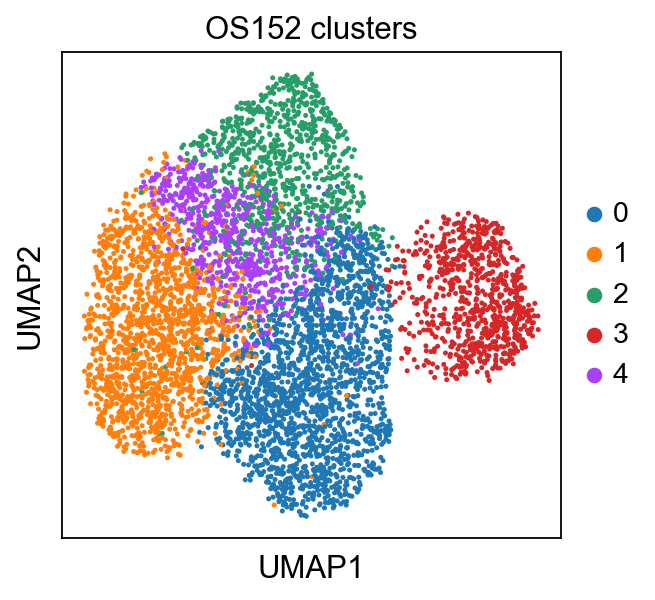

In [23]:
# plotting the clusters
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    frameon=True, 
    title = "OS152 clusters"
)

# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'Subtype A Source': ['4'], 'Subtype A Terminal State': ['2']}


# Initialize empty column in cell metadata
adata.obs['Subtype_A'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden_scVI).isin(cell_dict[i])
    adata.obs.loc[ind,'A_Source'] = i

    
sc.pl.umap(adata, color=['A_Source'], legend_fontsize=9, title = 'Subtype A')

# performing dgea between two subtypes
de_df = model.differential_expression(
    groupby='A_Source',
    group1='Subtype A Source',
    group2='Subtype A Terminal State'
)

de_df.head(30)

computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on distances
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/283 [00:00<?, ?gene/s]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:03:21) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/6490 [00:00<?, ?cells/s]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


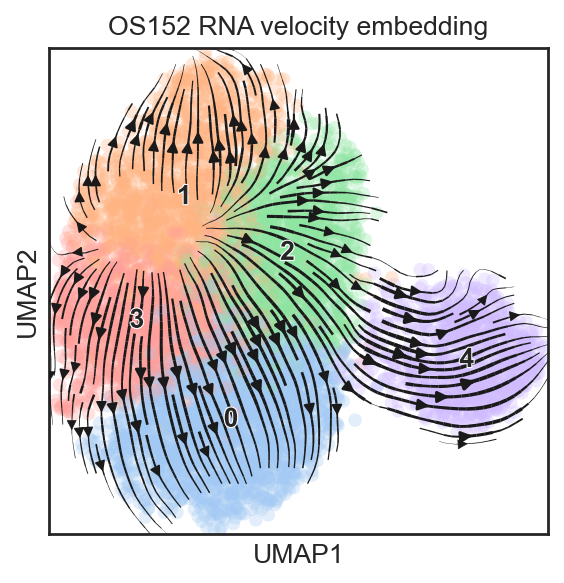

In [16]:
# computing the moments
scv.pp.moments(adata, mode = 'distances')
 

# recovering dynamics
scv.tl.recover_dynamics(adata)

# inferring the DYNAMIC velocities
scv.tl.velocity(adata, mode='dynamical')


# computing the velocity graph
scv.tl.velocity_graph(adata)

# creating a dataframe with the cluster IDs
clusters = pd.DataFrame(adata.obs['leiden'].astype('int64').values)

# Define the number of clusters
n_clusters = len(clusters[0].unique())

# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_clusters)

# Create a dictionary that maps each cluster ID to a color from the palette
cluster_colors = dict(zip(sorted(clusters[0].unique()), colors))

# Map the cluster IDs to their corresponding colors
adata.uns['ClusterName_colors'] = [cluster_colors[c] for c in clusters[0]]

# Set the plot style to 'white' to remove grid lines
sns.set_style('white')

# Plot the stream with the discrete color legend
scv.pl.velocity_embedding_stream(adata, basis='umap', color='leiden', 
                                 palette=colors, title = 'OS152 RNA velocity embedding',
                                frameon = True)

# Cell Cycle

In [11]:
!if [ ! -f regev_lab_cell_cycle_genes.txt ]; then curl -o regev_lab_cell_cycle_genes.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi

In [27]:
cell_cycle_genes = [x.strip() for x in open('./regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

97
77


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    544 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    458 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


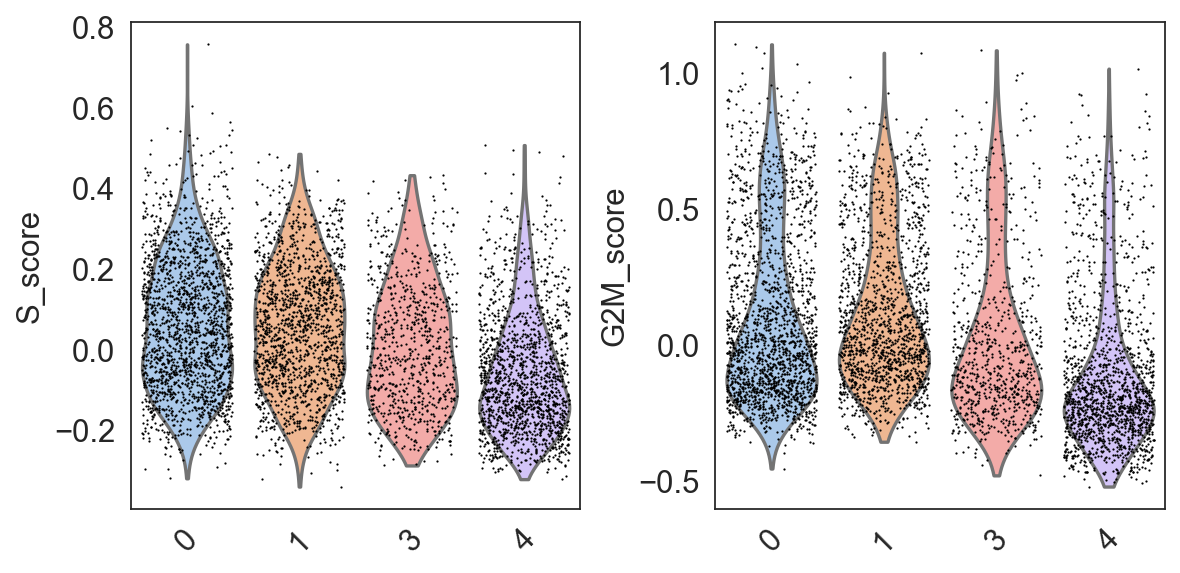

In [28]:
# save normalized counts in raw slot.
adata.raw = adata

# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# log normalization
sc.pp.log1p(adata)

# scale
sc.pp.scale(adata)

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)


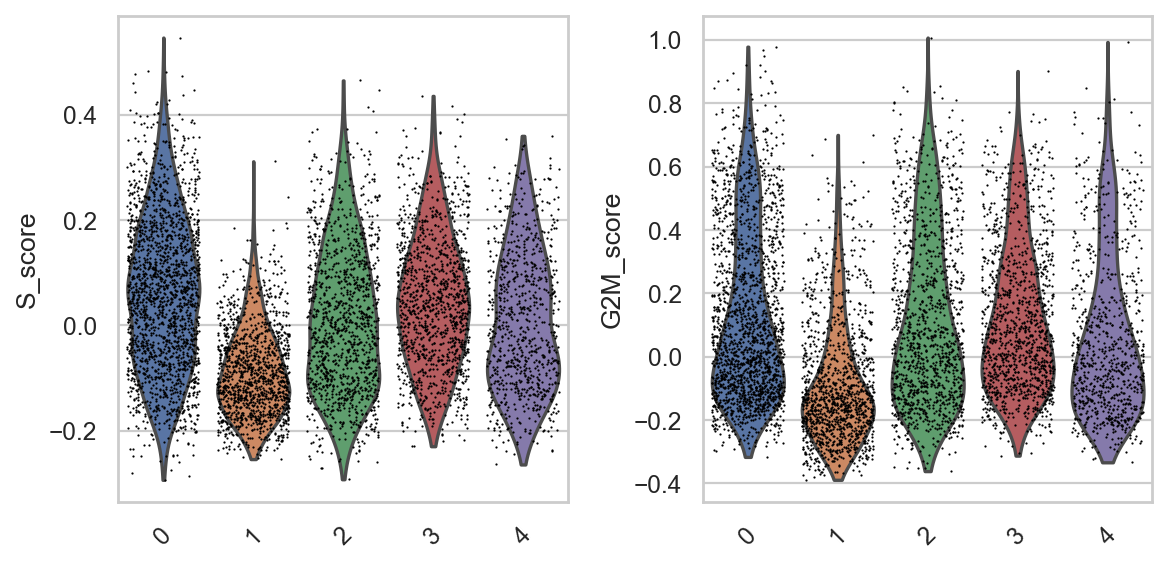

In [14]:

sc.pl.violin(adata, ['S_score', 'G2M_score'],
             jitter=0.4, groupby = 'leiden', rotation=45)

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


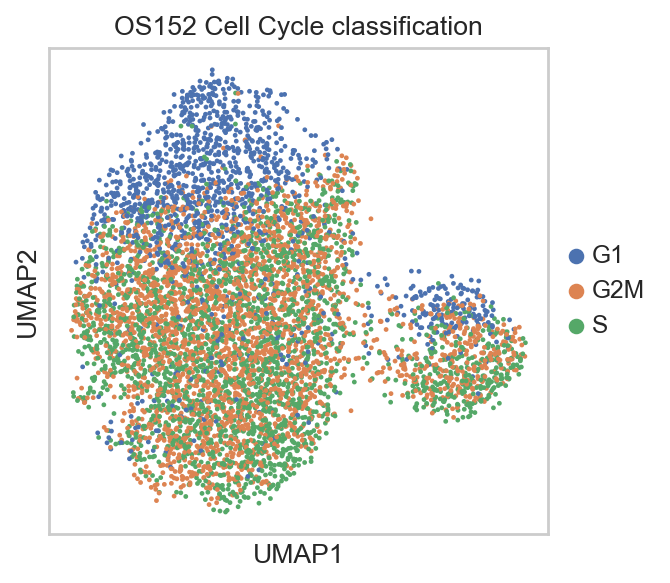

In [15]:
sc.pl.umap(
    adata,
    color=["phase"],
    frameon=True,
    title = 'OS152 Cell Cycle classification'
)

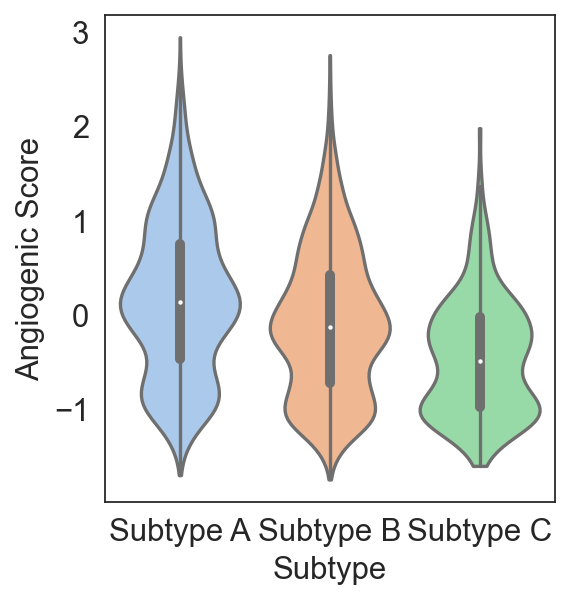

In [22]:
sc.pl.violin(adata, ['angiogenic_score'], groupby='Subtype', stripplot=False, inner='box', title = 'Subtype A enrichment in clusters', ylabel = 'Angiogenic Score')


In [24]:
# Chi-squared analysis for cells in G1 and Subtype A and those not in Subtype A

n_counts  ccdifference  percent.mt   S_score  G2M_score  \
CellID                                                                       
AAACGCTGTACCCGCA -21.981001      0.233552    4.313305 -0.086393  -0.318022   
AAACCCAAGGCTCACC  -6.191926     -0.531720    4.351523 -0.100041   0.528720   
AACAAAGGTGTGTTTG -32.800579     -0.684280    5.155145 -0.159992   0.671631   
AAAGGGCCAGTTGTCA -23.688530     -0.627821    3.764805 -0.056039   0.596937   
AAAGGGCTCTCCAAGA  46.618778     -0.612506    3.889324 -0.173941   0.566107   
...                     ...           ...         ...       ...        ...   
TTTGATCGTTCGGGTC   6.226318      0.421990    3.770641  0.202241  -0.111854   
TTTGATCTCCGCACTT -31.418264     -0.769027    2.851748 -0.166050   0.782455   
TTTGGTTCAACTGCCG  12.060676      0.253632    6.489547  0.114821  -0.075929   
TTTGGTTGTAACACGG  66.744110      0.176092    4.741074  0.078336   0.164904   
TTTGGTTTCCGACAGC  -8.091204      0.294394    4.272446  0.337046   0.063757   

                 phase leiden  velocity_self_transition  angiogenic_score  \
CellID                                                                      
AAACGCTGTACCCGCA    G1      1                  0.339203         -0.914261   
AAACCCAAGGCTCACC   G2M      1                  0.148956         -0.523401   
AACAAAGGTGTGTTTG   G2M      1                  0.212289         -0.548020   
AAAGGGCCAGTTGTCA   G2M      1                  0.312240          1.292902   
AAAGGGCTCTCCAAGA   G2M      2                  0.087709          0.036847   
...                ...    ...                       ...               ...   
TTTGATCGTTCGGGTC     S      1                  0.193868         -0.016417   
TTTGATCTCCGCACTT   G2M      1                  0.181032         -0.627780   
TTTGGTTCAACTGCCG     S      1                  0.183715         -1.152934   
TTTGGTTGTAACACGG   G2M      1                  0.032102         -0.302960   
TTTGGTTTCCGACAGC     S      1                  0.162261          0.265971   

                  ImmuneModulating_score    Subtype  
CellID                                               
AAACGCTGTACCCGCA               -1.294473  Subtype B  
AAACCCAAGGCTCACC                0.686901  Subtype B  
AACAAAGGTGTGTTTG                0.978515  Subtype B  
AAAGGGCCAGTTGTCA                0.582840  Subtype B  
AAAGGGCTCTCCAAGA                1.298744  Subtype A  
...                                  ...        ...  
TTTGATCGTTCGGGTC               -0.291617  Subtype B  
TTTGATCTCCGCACTT                0.908079  Subtype B  
TTTGGTTCAACTGCCG                0.414303  Subtype B  
TTTGGTTGTAACACGG                0.383462  Subtype B  
TTTGGTTTCCGACAGC                0.345068  Subtype B  

[5775 rows x 11 columns]

In [28]:
# Small constant to avoid zero counts in the contingency table
epsilon = 1e-5
obs_data = adata.obs

# Create a contingency table
# Rows: depleted_10X status (True/False)
# Columns: Inside or outside cluster 3
contingency_table = pd.DataFrame(
    [
        [
            ((obs_data['phase'] == 'G1') & (obs_data['Subtype'] == 'Subtype A')).sum(),  # True in cluster 3
            ((obs_data['phase'] == 'G1') & (obs_data['Subtype'] != 'Subtype A')).sum(),  # True outside cluster 3
        ],
        [
            ((obs_data['phase'] != 'G1') & (obs_data['Subtype'] == 'Subtype A')).sum(),  # False in cluster 3
            ((obs_data['phase'] != 'G1') & (obs_data['Subtype'] != 'Subtype A')).sum(),  # False outside cluster 3
        ],
    ],
    index=["Phase_G1", "Phase_other"],
    columns=["Subtype A", "Other subtype"]
)


In [30]:
contingency_table

Subtype A  Other subtype
Phase_G1           866            596
Phase_other        833           3480

In [31]:
chi2, p, _, _ = chi2_contingency(contingency_table)

In [34]:
# If your data needs a small constant to be added to avoid issues with zeros, you can add it here
epsilon = 1e-10  # Or whatever small number is appropriate for your dataset
contingency_table += epsilon

# Perform chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)

# Set a significance threshold (e.g., 0.05)
significance_threshold = 0.05

# Check if the result is significant
is_significant = p < significance_threshold

print(contingency_table)
print(f"Chi2: {chi2}")
print(f"P-value: {p}")
print(f"Significant: {'Yes' if is_significant else 'No'}")

             Subtype A  Other subtype
Phase_G1         866.0          596.0
Phase_other      833.0         3480.0
Chi2: 836.0654139361536
P-value: 7.780439588163765e-184
Significant: Yes


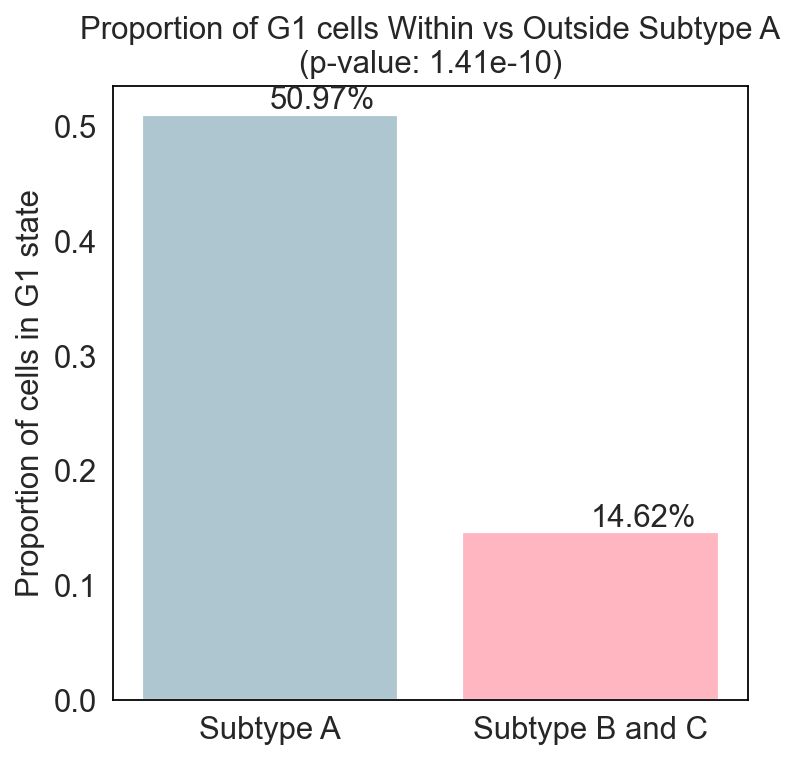

In [35]:
# Assuming 'barcode_data' is your DataFrame and 'depleted_10X' and 'leiden_scVI' are columns
# Calculate the proportions
Subtype_A_G1 = obs_data[(obs_data['Subtype'] == 'Subtype A') & (obs_data['phase'] == 'G1')]
Subtype_A_all = obs_data[obs_data['Subtype'] == 'Subtype A']

Subtype_B_C_G1 = obs_data[(obs_data['Subtype'] != 'Subtype A') & (obs_data['phase'] == 'G1')]
Subtype_B_C_all = obs_data[obs_data['Subtype'] != 'Subtype A']

prop_in_Subtype_A = len(Subtype_A_G1) / len(Subtype_A_all)
prop_outside_Subtype_A = len(Subtype_B_C_G1) / len(Subtype_B_C_all)

# Data to plot
categories = ['Subtype A', 'Subtype B and C']
proportions = [prop_in_Subtype_A, prop_outside_Subtype_A]

# Create bar chart
plt.figure(figsize=(5,5))
bars = plt.bar(categories, proportions, width=0.8, color=['#aec6cf', '#ffb6c1'])  # pastel blue and pink

# Add a border around the chart
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_color('black')

# Remove gridlines
plt.grid(False)

# Add labels and title (with p-value)
p_value = 1.410162683642539e-10
plt.ylabel('Proportion of cells in G1 state', fontsize=14)
plt.title(f'Proportion of G1 cells Within vs Outside Subtype A\n(p-value: {p_value:.2e})', fontsize=14)

# Add value labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2%}', va='bottom', fontsize=14)  # va: vertical alignment, percentage formatting

plt.tight_layout()
plt.show()
